# Network Visualisation
Felix Zaussinger | 07.06.2021

## Core Analysis Goal(s)
1. visualise adjacency matrix as network based on maximum spanning tree algorithm

## Key Insight(s)
1. networkx does not create nice visualizations
1. when coloring nodes by isco 1-digit codes, there are no clusters, which is
kind of weird

In [1]:
import os
import sys
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2


import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("ticks")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

import networkx as nx
import pyvis

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

Define directory structure

In [2]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_interim = os.path.join(project_dir, "data", "interim")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "reports", "figures")

Read metadata

In [3]:
df_metadata = pd.read_csv(
    os.path.join(data_interim, "ESCO_ONET_METADATA.csv"),
    index_col=0
)

df_metadata.greenness_vona_2018 = df_metadata.greenness_vona_2018.fillna(0)

# convert job zone to categorical var
df_metadata.job_zone = pd.Categorical(df_metadata.job_zone, ordered=True)

Read adjacency matrix from Nesta MCC report

In [4]:
# nesta report
sim_kanders = np.load(
    os.path.join(data_raw, "mcc_data", "processed", "sim_matrices", "OccupationSimilarity_Combined.npy")
)

np.fill_diagonal(sim_kanders, 0)

In [5]:
occ = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "occupations_en.csv"))

# reindex by isco level
reindex_by_isco4 = occ.sort_values("iscoGroup").index.values
x, y = np.meshgrid(reindex_by_isco4, reindex_by_isco4)

In [6]:
# construct graph and MST
G = nx.from_numpy_array(sim_kanders[x, y])

# construct maximum spanning tree
T = nx.maximum_spanning_tree(G)

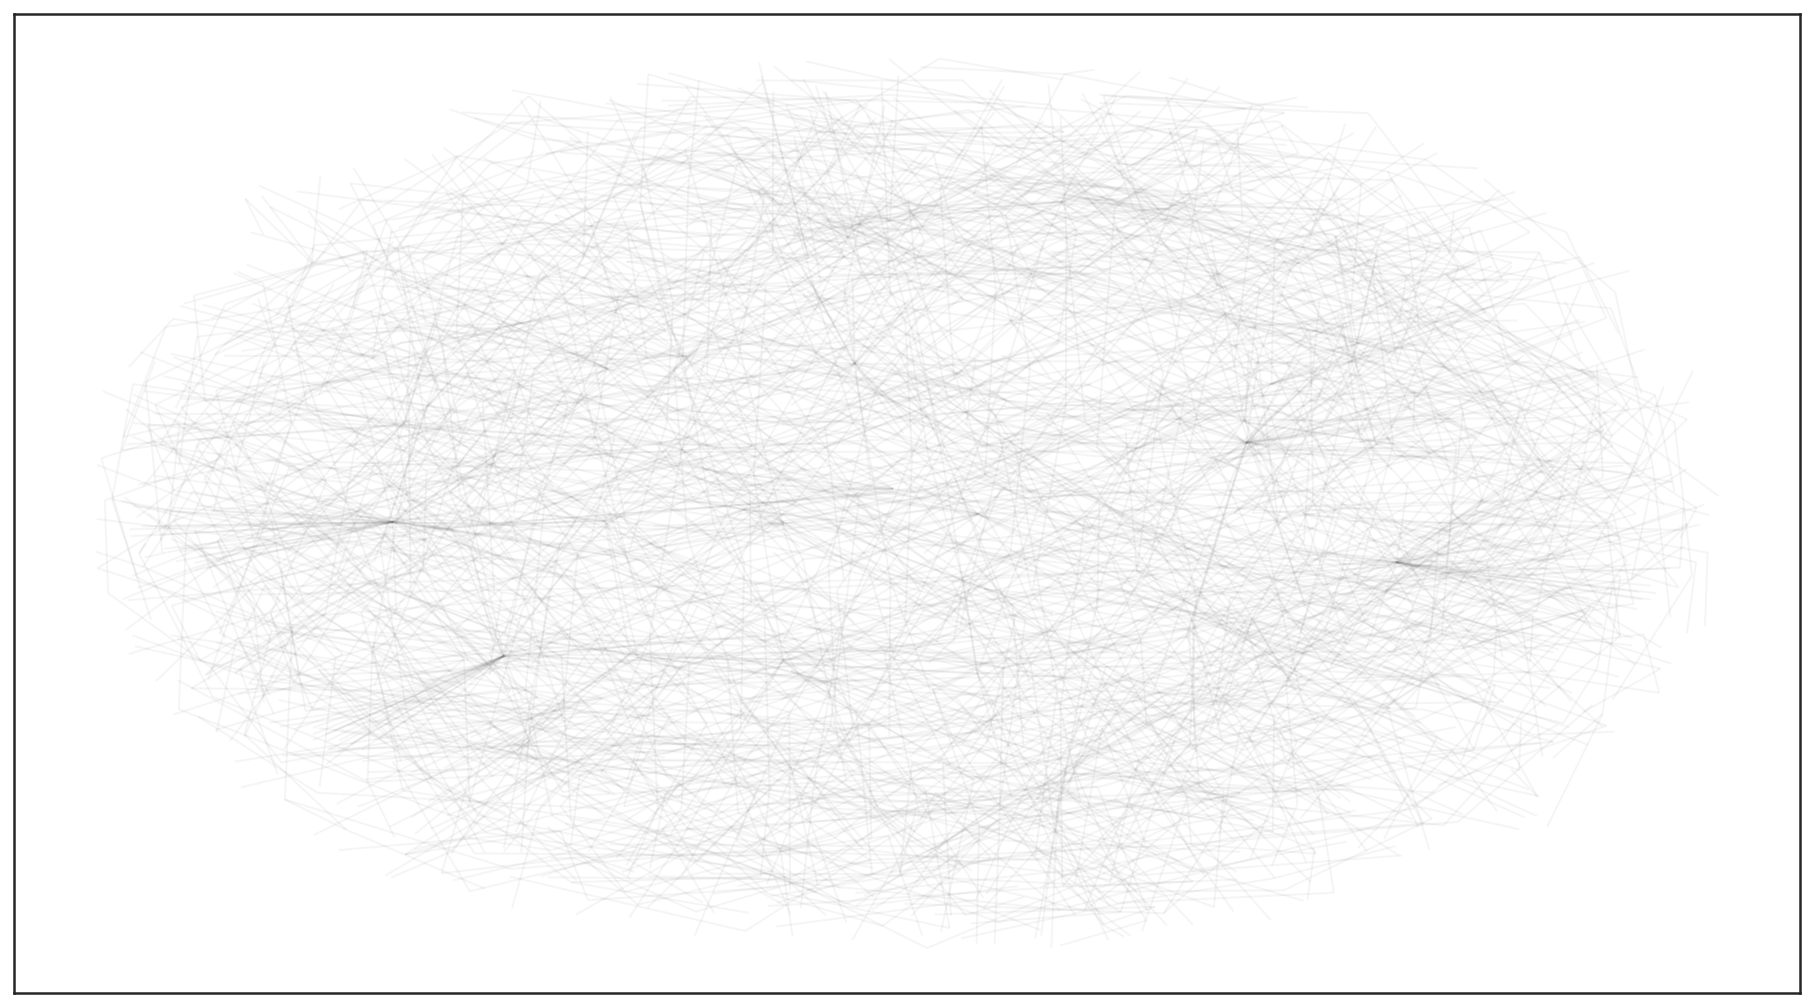

In [7]:
pos = nx.spring_layout(T, k=0.1)

nx.draw_networkx(
        T,
        pos=pos,
        node_size=0,
        edge_color="#444444",
        alpha=0.05,
        with_labels=False)

## Experiments with centrality measures

- nx.degree_centrality: same for every node, because all nodes are interconnected
- nx.betweenness_centrality: took ages to run, stopped computation

## Experiments with community detection

In [8]:
import community as community_louvain
partition = community_louvain.best_partition(T)

In [9]:
max(partition.values())

57

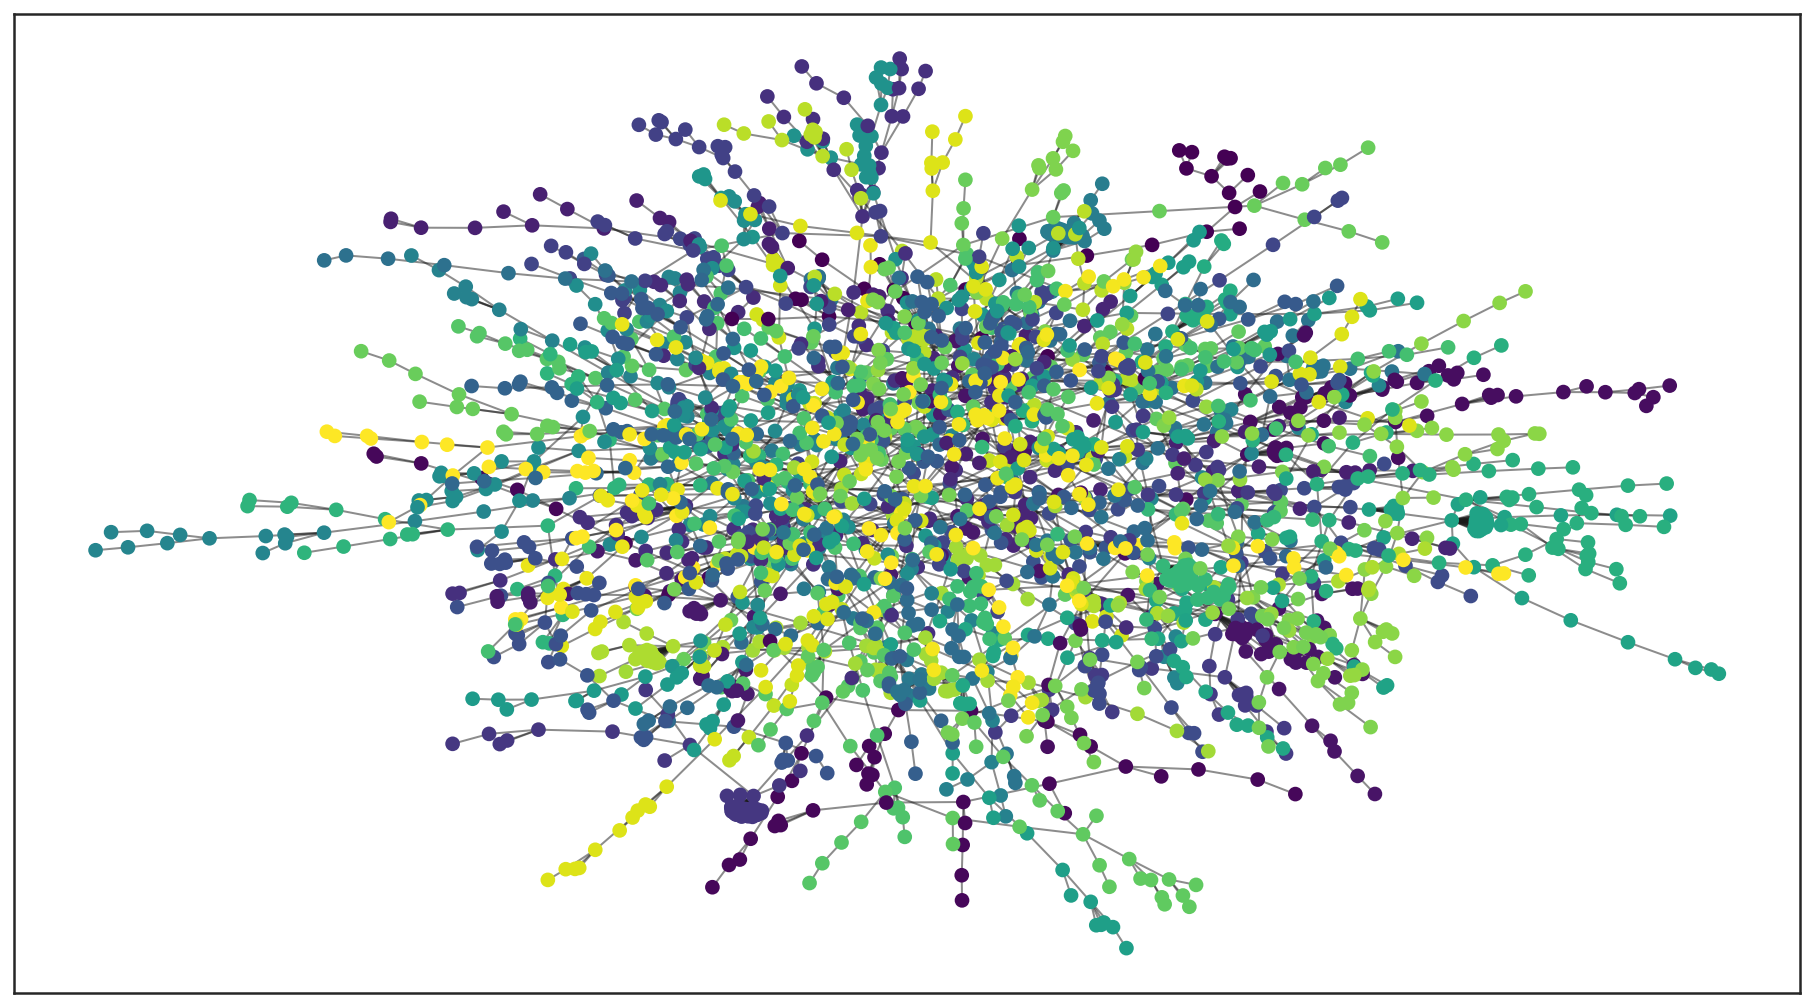

In [10]:
import matplotlib.cm as cm

# draw the graph
pos = nx.spring_layout(T)

# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(T, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(T, pos, alpha=0.5)
plt.show()

## Color nodes by greenness

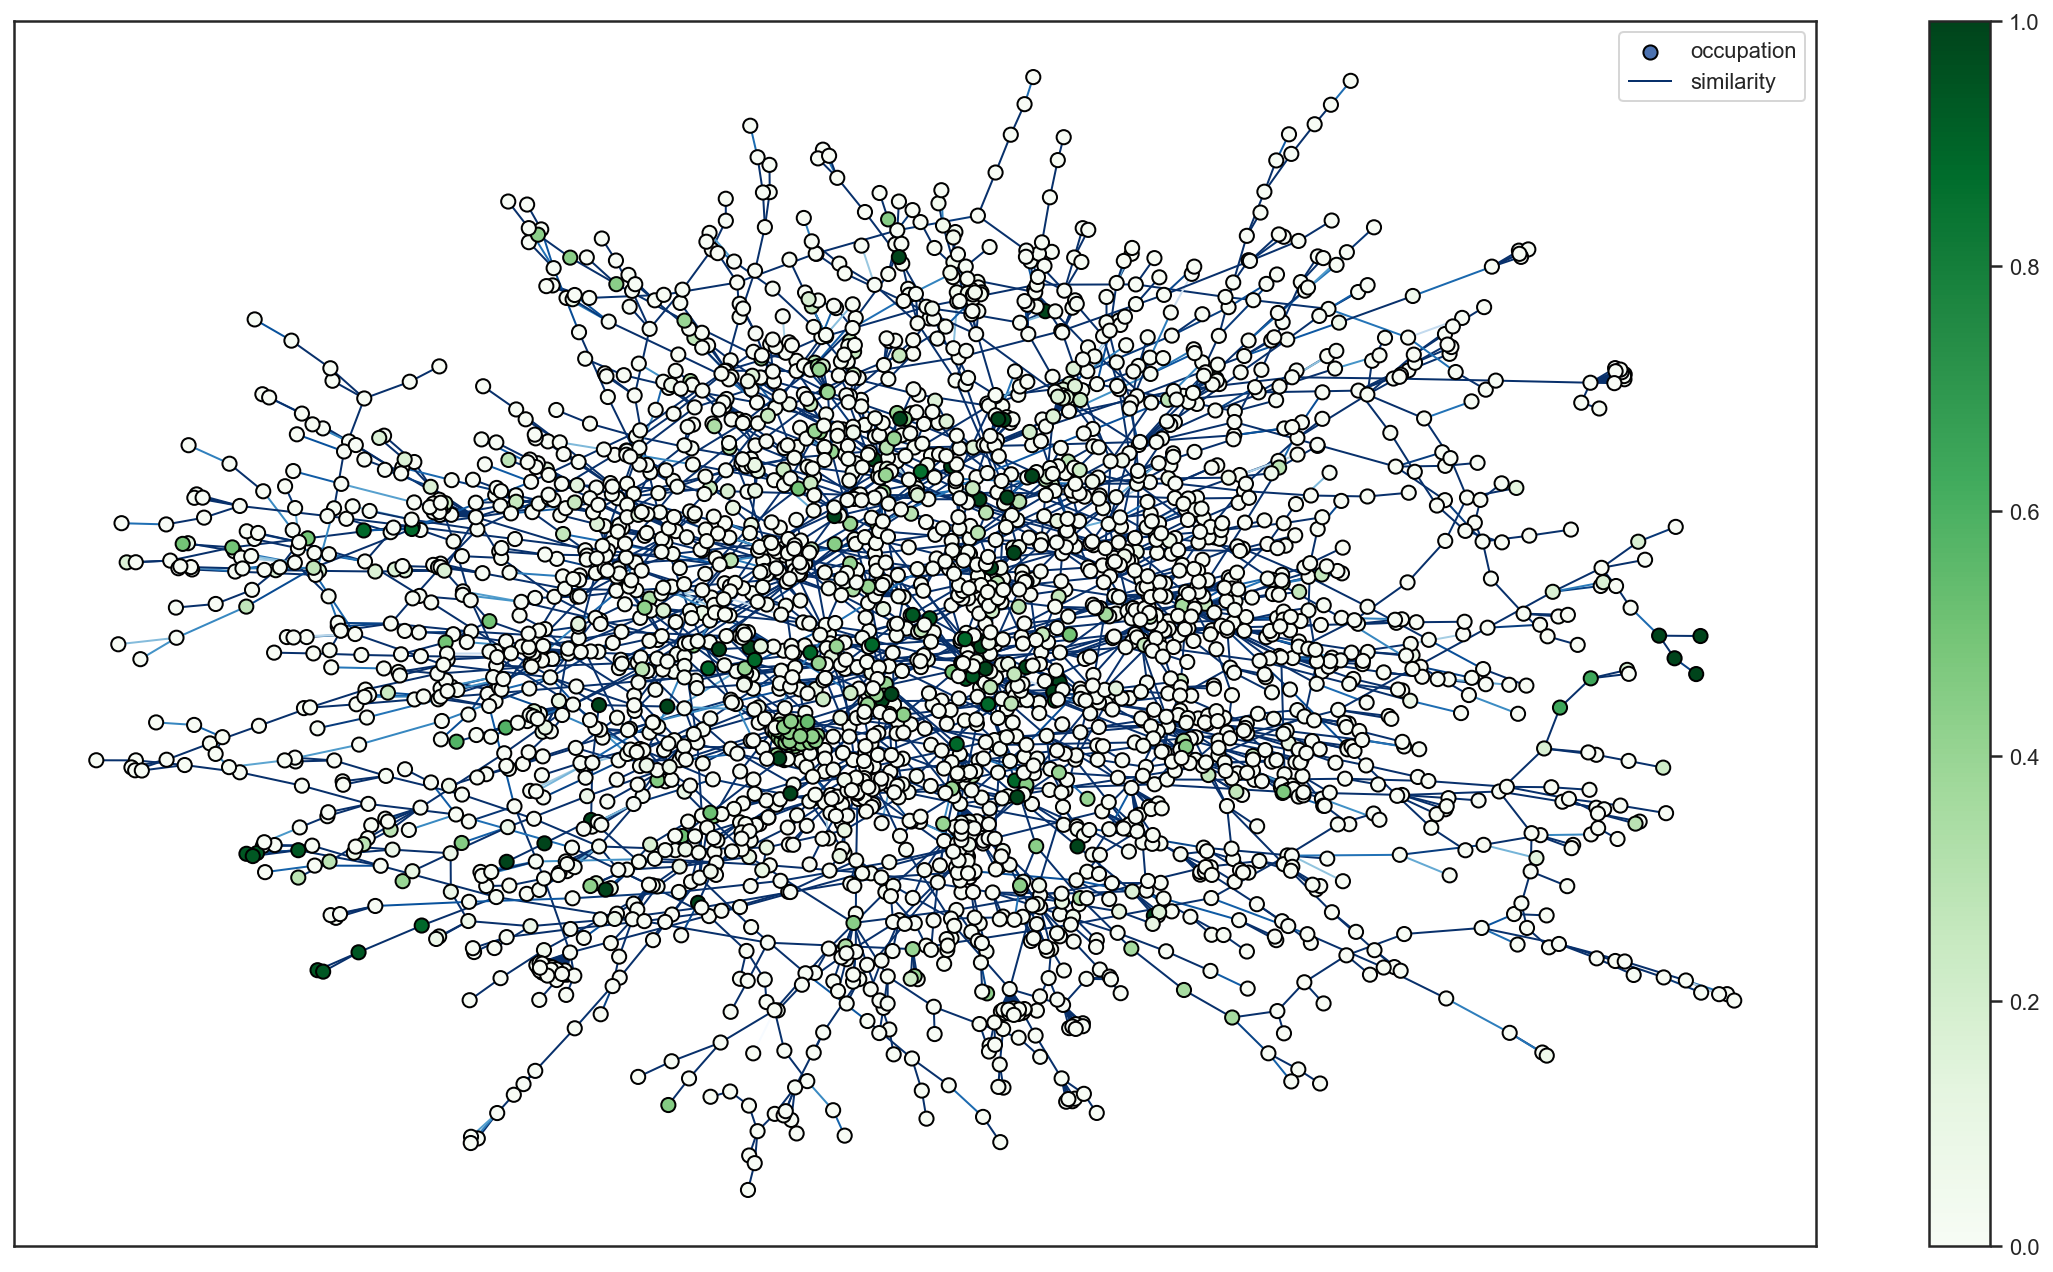

In [5]:
# set node color a function of greenness
greenness = df_metadata.greenness_vona_2018.values

# node labels dict
node_labels = dict(zip(np.arange(sim_kanders.shape[0]), df_metadata.preferred_label.values))
node_cmap = plt.cm.Greens

# plot
pos = nx.layout.spring_layout(T)
weights = nx.get_edge_attributes(T,'weight')

# draw nodes
nodes = nx.draw_networkx_nodes(
    T,
    pos,
    node_size=50,
    node_color=greenness,
    cmap=node_cmap,
    edgecolors="black",
    label="occupation"
)

# draw node labels
nx.draw_networkx_labels(
    T,
    pos,
    node_labels,
    font_size=10,
    alpha=0.0,
    horizontalalignment="left",
    verticalalignment="bottom"
)

# draw edges
colors = list(weights.values())
options = {
    "edge_color": colors,
    "width": 1,
    "edge_cmap": plt.cm.Blues
}

edges = nx.draw_networkx_edges(T, pos, edge_vmax=0.5, label="similarity", **options)

# colorbar
sm = plt.cm.ScalarMappable(cmap=node_cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm)

# legend
plt.legend()
plt.tight_layout()

# save
plt.savefig(
    os.path.join(figure_dir, "mst_nesta_adjacency_matrix_greenness.png"),
    dpi=300,
)

## Color nodes by ISCO 1-digit level

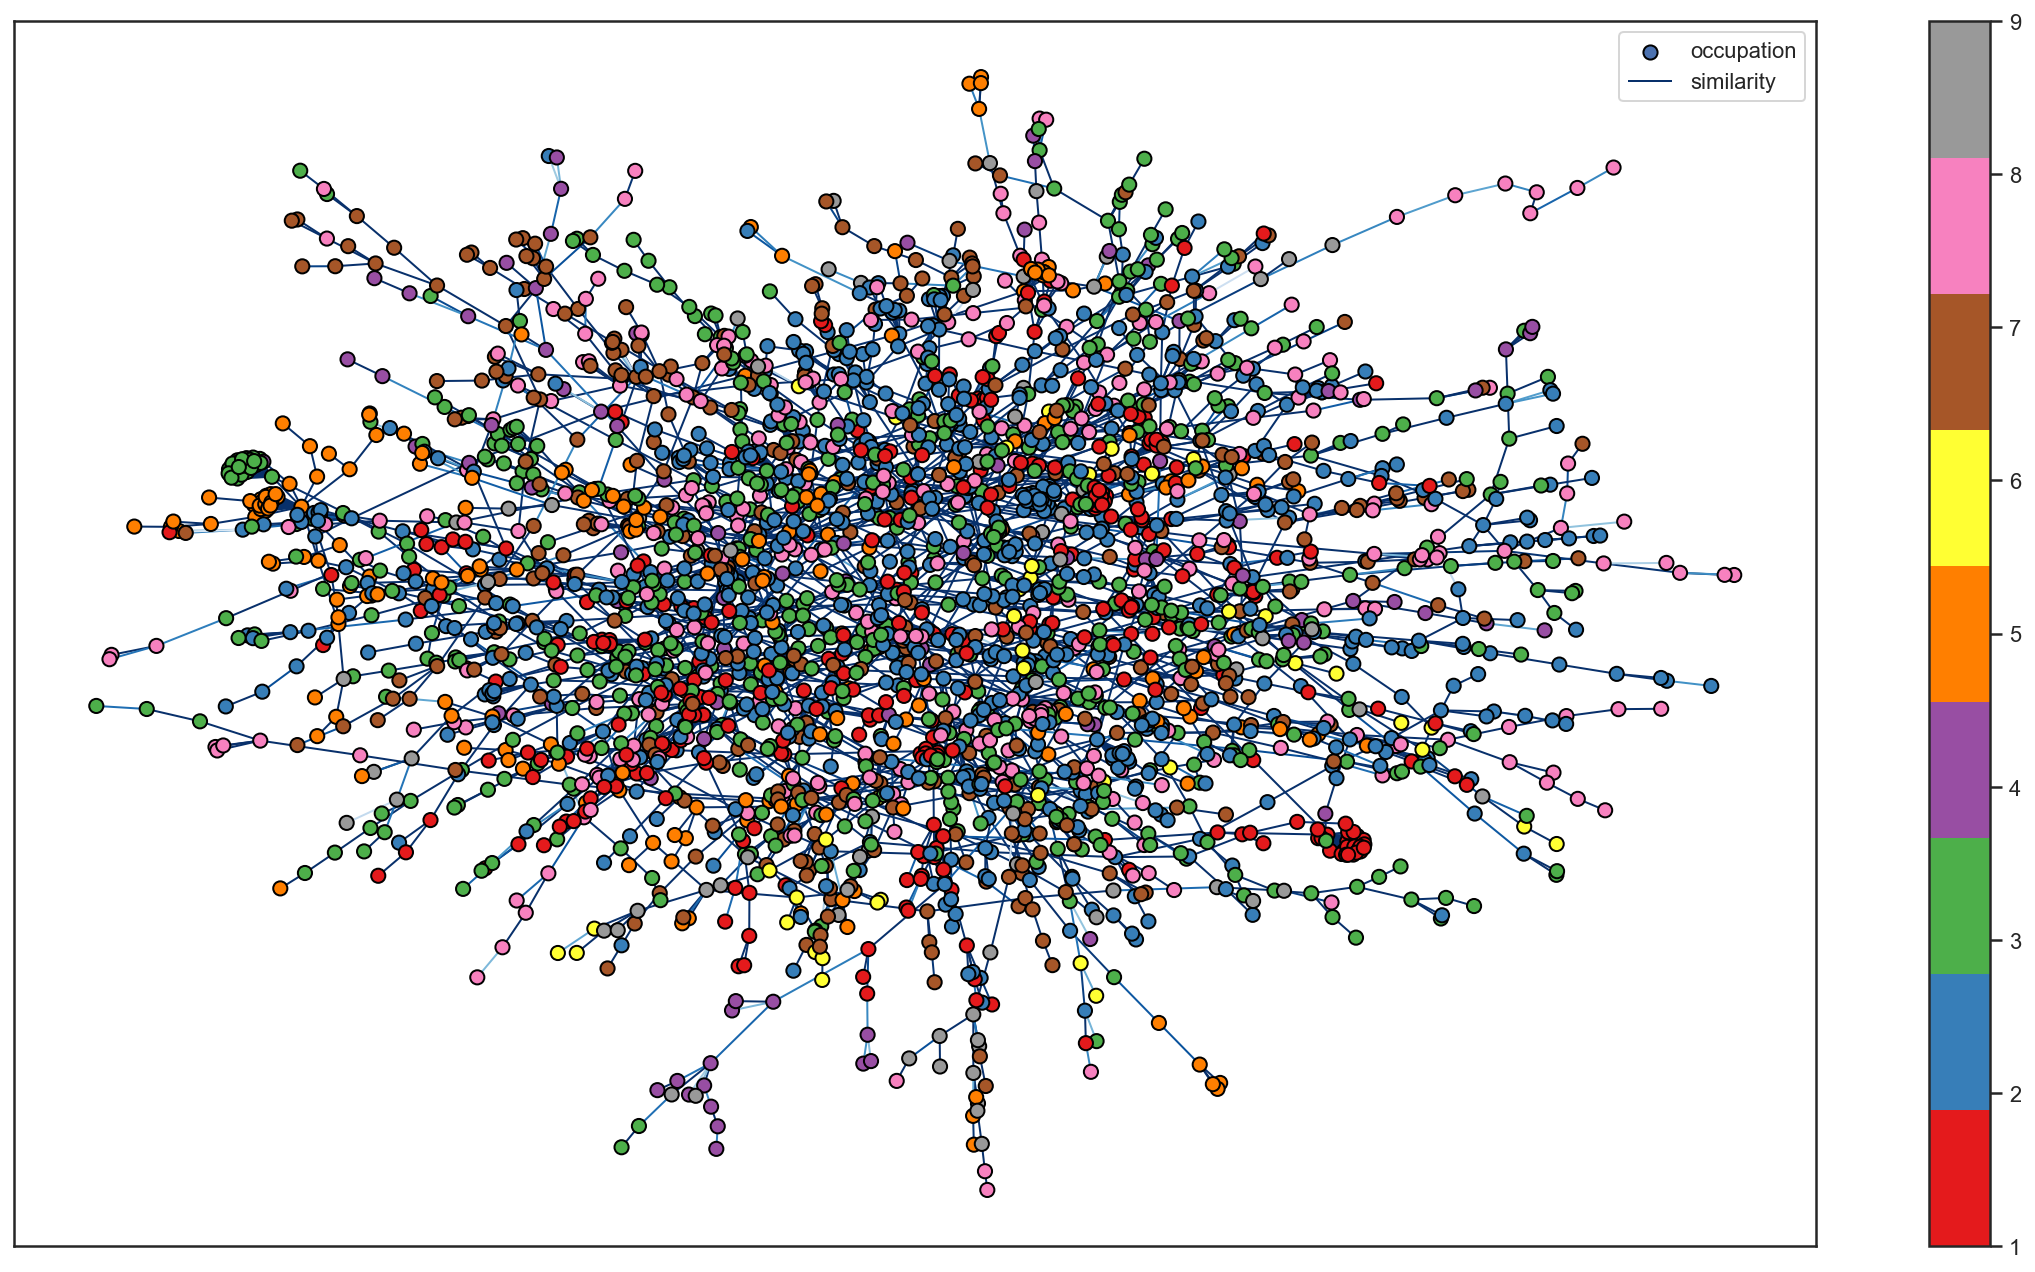

In [6]:
# set node color a function of greenness
node_color = df_metadata.isco_level_1.values
node_cmap = plt.cm.Set1

# node labels dict
node_labels = dict(zip(np.arange(sim_kanders.shape[0]), df_metadata.preferred_label.values))

# plot
pos = nx.layout.spring_layout(T)
weights = nx.get_edge_attributes(T,'weight')

# draw nodes
nodes = nx.draw_networkx_nodes(
    T,
    pos,
    node_size=50,
    node_color=node_color,
    cmap=node_cmap,
    edgecolors="black",
    label="occupation"
)

# draw node labels
nx.draw_networkx_labels(
    T,
    pos,
    node_labels,
    font_size=10,
    alpha=0.0,
    horizontalalignment="left",
    verticalalignment="bottom"
)

# draw edges
colors = list(weights.values())
options = {
    "edge_color": colors,
    "width": 1,
    "edge_cmap": plt.cm.Blues
}

edges = nx.draw_networkx_edges(T, pos, edge_vmax=0.5, label="similarity", **options)

# colorbar
sm = plt.cm.ScalarMappable(cmap=node_cmap, norm=plt.Normalize(vmin=1, vmax=9))
sm.set_array([])
cbar = plt.colorbar(sm)

# legend
plt.legend()
plt.tight_layout()

# save
plt.savefig(
    os.path.join(figure_dir, "mst_nesta_adjacency_matrix_isco1.png"),
    dpi=300,
)

## Pyvis visualisation

In [17]:
from pyvis import network as net

g = net.Network(notebook=True)
g.from_nx(T)
g.show("test.html")

## Write to Gephi

In [21]:
# populate dictionary of node attributes
attr_dict = {}
for i in np.arange(sim_kanders.shape[0]):
    attr_dict[i] = {
        "label": df_metadata.preferred_label.values[i],
        "greenness": df_metadata.greenness_vona_2018.values[i],
        "isco_01": df_metadata.isco_level_1.values[i],
        "isco_02": df_metadata.isco_level_2.values[i],
        # "annual_earnings": df_metadata.annual_earnings.values[i],
    }

# set attributes
nx.set_node_attributes(G, attr_dict)

# MST
T = nx.maximum_spanning_tree(G)

In [24]:
# export to GraphML files
#nx.write_gexf(G, os.path.join(data_raw, "networks", "occ_sim_nesta.gexf"))
#nx.write_gexf(T, os.path.join(data_raw, "networks", "mst_occ_sim_nesta.gexf"))

nx.write_graphml(T, os.path.join(data_raw, "networks", "mst_occ_sim_nesta.graphml"))

## Experiment with other visualizations and clustering methods

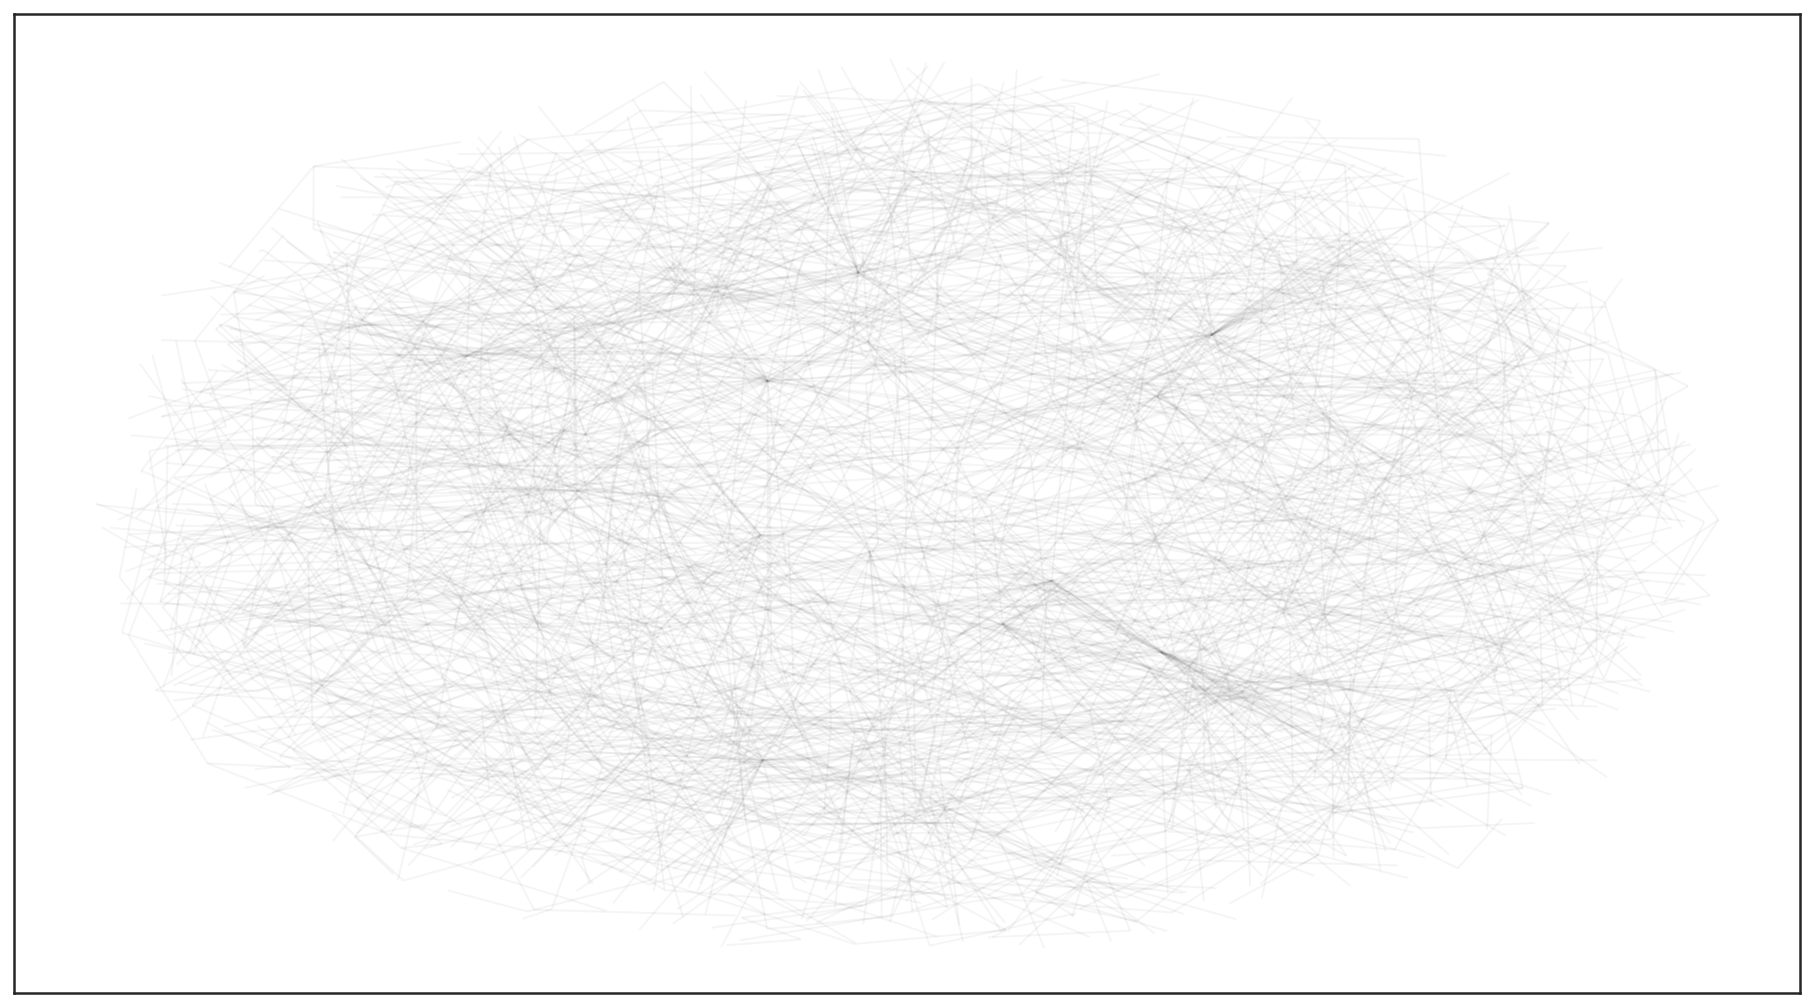

In [6]:
pos = nx.spring_layout(T, k=0.1)

nx.draw_networkx(
        T,
        pos=pos,
        node_size=0,
        edge_color="#444444",
        alpha=0.05,
        with_labels=False)

In [10]:
# https://orbifold.net/default/community-detection-using-networkx/

def set_node_community(G, communities):
        '''Add community to node attributes'''
        for c, v_c in enumerate(communities):
            for v in v_c:
                # Add 1 to save 0 for external edges
                G.nodes[v]['community'] = c + 1

def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0

def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

In [13]:
import networkx.algorithms.community as nxcom

communities = sorted(nxcom.greedy_modularity_communities(T), key=len, reverse=True)
len(communities)


2942

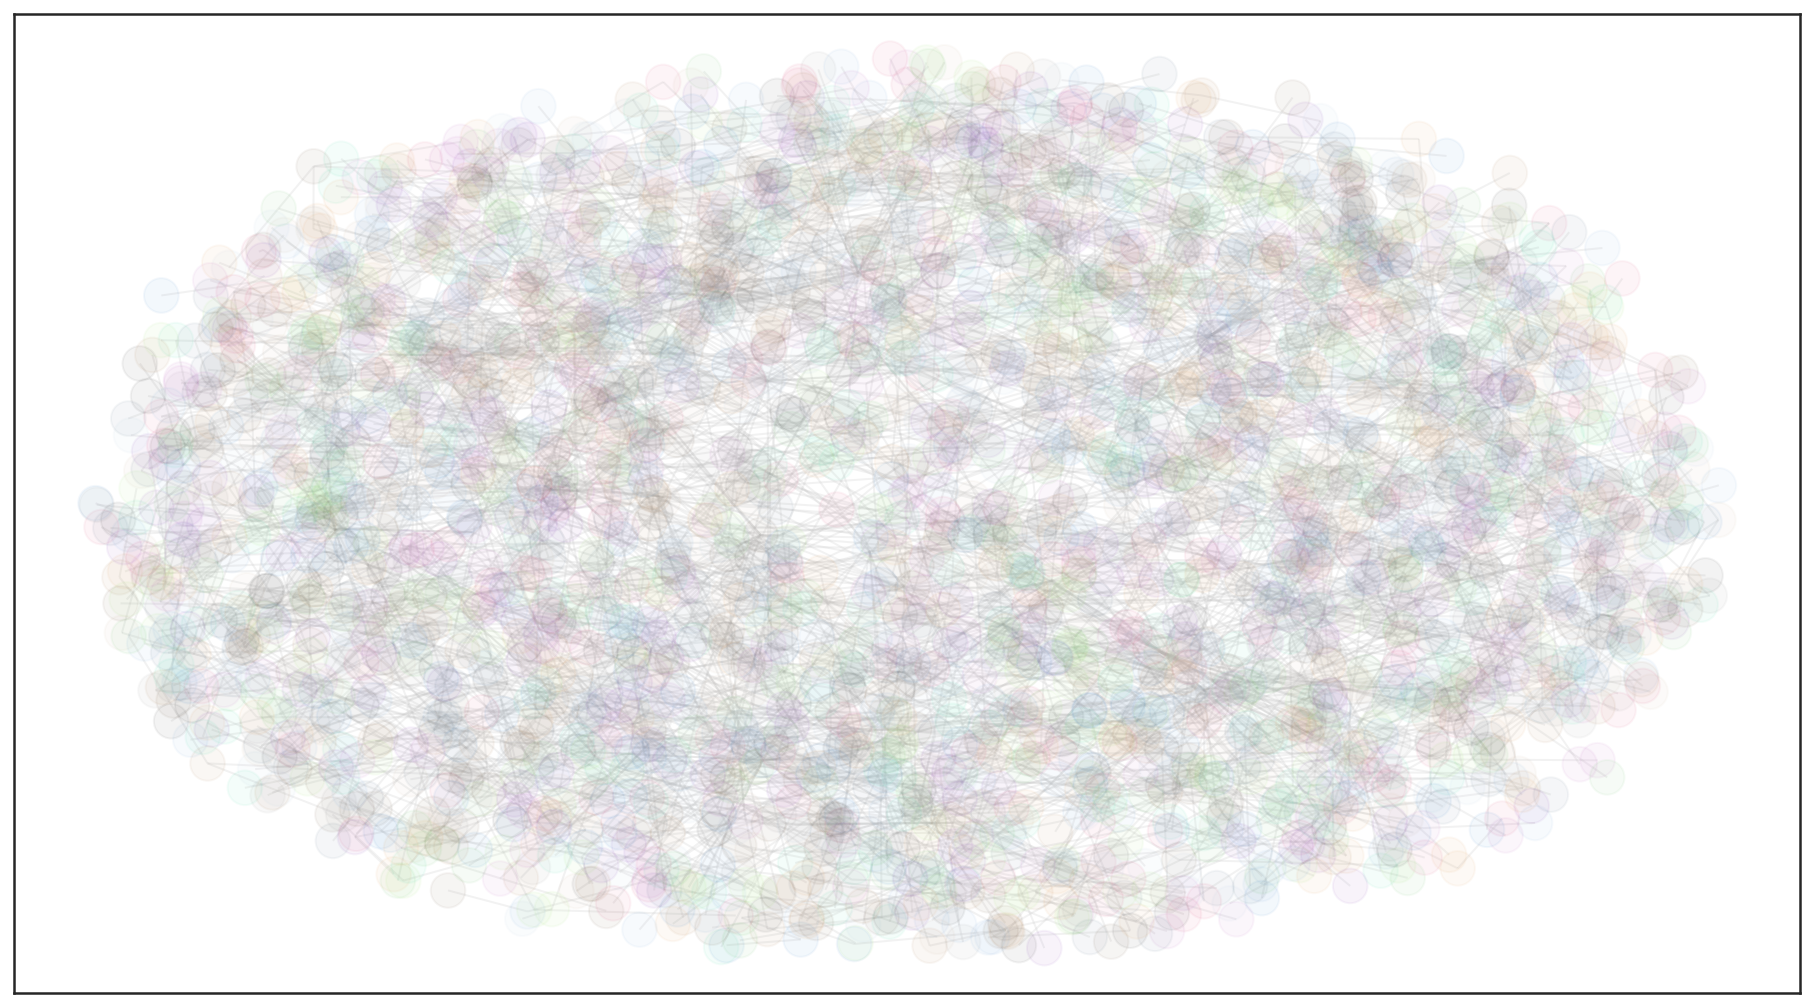

In [14]:
set_node_community(T, communities)
set_edge_community(T)

# Set community color for internal edges
external = [(v, w) for v, w in T.edges if T.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in T.edges if T.edges[v, w]['community'] > 0]
internal_color = ["black" for e in internal]
node_color = [get_color(T.nodes[v]['community']) for v in T.nodes]

# external edges
nx.draw_networkx(
    T,
    pos=pos,
    node_size=0,
    edgelist=external,
    edge_color="silver",
    node_color=node_color,
    alpha=0.2,
    with_labels=False)

# internal edges
nx.draw_networkx(
    T, pos=pos,
    edgelist=internal,
    edge_color=internal_color,
    node_color=node_color,
    alpha=0.05,
    with_labels=False)